## Defining initial modules

In [1]:
import sys
sys.path.append("../")
sys.path.append("./")

In [2]:
import os
import pandas
import albumentations 
import matplotlib.pyplot as plt 
from PIL import Image
import numpy
import typing
import warnings
import torch 
from torch import optim

from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Defining data urls

In [3]:
# training images and masks

train_images_path = "../data/train/train/images_size_400/"
train_image_masks_path = "../data/train/train/masks_size_400/"

# train images and masks

first_exp_train_urls = [
    ("../data/train/train/images_size_400/", "../data/train/train/masks_size_400/"),
    ("../data/train/train/images_size_500/", "../data/train/train/masks_size_500/"),
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
]

first_exp_validation_urls = [
    ("../data/train/_extra/images_size_500/", "../data/train/_extra/masks_size_500/"),
]


second_exp_train_urls = [
    ("../data/train/train/images_size_500/", "../data/train/train/masks_size_500/"),
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
    ("../data/train/train/images_size_700/", "../data/train/train/masks_size_700/"),
]

second_exp_validation_urls = [
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
]

## Loading small batch of images and masks for initial analysis

In [4]:
def load_files(file_path: str):
    """
    Function loads files from given 'file_path' source
    Args:
        - file_path - path, pointing to the files directory
        - number_of_files - respective number of files to load
    """
    batch = []
    for path in os.listdir(file_path):
        try:
            full_url = os.path.join(file_path, path)
            ext = path.split(".")[-1]
            if ext in ('jpeg', 'png', 'jpg'):
                batch.append(full_url)
                
        except(FileNotFoundError):
            print('file not found: %s' % full_url)
    return batch

In [5]:
def load_experiment_data(urls: typing.Tuple[str]):
    """
    Function loads data for experiment
    
    urls: (img_url, mask_url) - list of tuples, containing
    corresponding images and masks with different resolutions
    """
    imgs, masks = [], []
    for img_path, mask_path in urls:
    
        imgs = load_files(file_path=train_images_path)
        masks = load_files(file_path=train_image_masks_path)

        imgs.extend(imgs)
        masks.extend(masks)
    return imgs, masks

# Loading training and validation sets for first experiment

In [6]:
%%time

f_train_imgs, f_train_masks = load_experiment_data(first_exp_train_urls)
f_validation_imgs, f_validation_masks = load_experiment_data(first_exp_validation_urls)

CPU times: user 42 ms, sys: 11.4 ms, total: 53.4 ms
Wall time: 55.2 ms


In [7]:
first_exp_train_info = pandas.DataFrame(
    {
        'image': f_train_imgs,
        'mask': f_train_masks
    }
)

first_exp_validation_info = pandas.DataFrame(
    {
        'image': f_validation_imgs,
        'mask': f_validation_masks
    }
)

# Loading training and validation sets for second experiment

In [8]:
s_train_imgs, s_train_masks = load_experiment_data(first_exp_train_urls)
s_validation_imgs, s_validation_masks = load_experiment_data(first_exp_validation_urls)

In [9]:
%%time

second_exp_train_info = pandas.DataFrame(
    {
        'image': s_train_imgs,
        'mask': s_train_masks
    }
)

second_exp_validation_info = pandas.DataFrame(
    {
        'image': s_validation_imgs,
        'mask': s_validation_masks
    }
)

CPU times: user 3.66 ms, sys: 0 ns, total: 3.66 ms
Wall time: 3.09 ms


# Visualizing images and masks

In [10]:
import typing

def visualize_set_of_images(imgs: typing.List, masks: typing.List):
    """
    Function visualizes image for a given
    set of data
    """
    _, ax = plt.subplots(ncols=2, nrows=5)
    plt.figure(figsize=(30, 30))

    for idx in range(5):
        
        img = Image.open(imgs[idx])
        mask = Image.open(masks[idx])
        
        ax[idx,0].imshow(img)
        ax[idx,1].imshow(mask, cmap='gray')

## Visualizing images and masks for training set (first experiment)

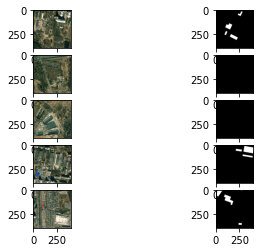

<Figure size 2160x2160 with 0 Axes>

In [11]:
visualize_set_of_images(f_train_imgs, f_train_masks)

## Visualizing images and masks for validation set (first experiment)

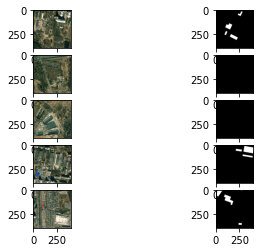

<Figure size 2160x2160 with 0 Axes>

In [12]:
visualize_set_of_images(f_validation_imgs, f_validation_masks)

## Defining Augmentation Pipeline

In [13]:
train_color_transformations = albumentations.Compose(
    [
        albumentations.OneOf([
            albumentations.ColorJitter(
                brightness=0.15,
                hue=0.15,
                saturation=0.15
            ),
            albumentations.FancyPCA()
        ])
    ]
)

## Defining Datasets for first experiment

In [14]:
from dataset.dataset import SegmentationDataset 

f_train_dataset = SegmentationDataset(
    imgs=first_exp_train_info['image'].tolist(),
    masks=first_exp_train_info['mask'].tolist(),
    color_transformations=train_color_transformations
)

f_validation_dataset = SegmentationDataset(
    imgs=first_exp_validation_info['image'].tolist(),
    masks=first_exp_validation_info['mask'].tolist(),
)

## Defining datasets for second experiment

In [15]:
s_train_dataset = SegmentationDataset(
    imgs=second_exp_train_info['image'].tolist(),
    masks=second_exp_train_info['mask'].tolist(),
    color_transformations=train_color_transformations
)

s_validation_dataset = SegmentationDataset(
    imgs=second_exp_validation_info['image'].tolist(),
    masks=second_exp_validation_info['mask'].tolist()
)

# Beginning of experiments.

### Defining loss functions and evaluation metrics for experiments

In [16]:
from losses.losses import DiceLoss, FocalLoss, ComboLoss

focal_gamma = 2

dice_loss = DiceLoss()
focal_loss = FocalLoss(gamma=focal_gamma)

combo_loss = ComboLoss(
    dice_prop=0.4, 
    focal_prop=0.6, 
    focal_gamma=focal_gamma
)

### Defining network for experiment

In [17]:
from networks import unet
network = unet.UNet()

### Defining optimizers and learning rate 

In [18]:
learning_rate = 3e-6
adam_opt = optim.Adam(params=network.parameters(), lr=learning_rate, weight_decay=1e-5)
sgd_opt = optim.SGD(params=network.parameters(), lr=learning_rate)

### Defining lr scheduling techniques

In [19]:
from torch.optim import lr_scheduler

reduction_gamma = 0.0001
step_size = 5
patience_epochs = 5

adam_step_scheduler = lr_scheduler.StepLR(
    optimizer=adam_opt,
    step_size=step_size, 
    gamma=reduction_gamma
)

sgd_step_scheduler = lr_scheduler.StepLR(
    optimizer=sgd_opt,
    step_size=step_size, 
    gamma=reduction_gamma
)

adam_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(
    adam_opt, mode='min', 
    factor=0.1,
    patience=patience_epochs, 
    min_lr=learning_rate
)

sgd_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(
    sgd_opt, mode='min', 
    factor=0.1,
    patience=patience_epochs, 
    min_lr=learning_rate
)

### Early Stopping Regularization

In [20]:
class EarlyStopping(object):
    """
    Implementation of the early stopping class
    for network regularization
    """
    def __init__(self, patience: int):
        self.default_patience = patience
        self.current_patience = patience
        self.best_metric = None
        
    def compare(self, current_metric: float):
        """
        Function compares current metric to
        previous one and updates the patience
        
        Returns:
            - bool status
            (True) - stop training 
            (False) - continue
        """
        if not self.best_metric:
            self.best_metric = current_metric
            
        elif current_metric > self.prev_metric:
            self.current_patience = self.default_patience
            self.best_metric = current_metric
        else:
            self.current_patience -= 1
        return self.current_patience == 0

In [51]:
import math

def pick_best_batch_size(model_size: float, forward_backward_size: float):
    """
    Function returns maximum batch size,
    that can be formed based on existing
    network and computational capabilities
    
    Following formula is applied: 
    max_batch_size = (total_gpu_bytes - model_size) / (forward_backward_size)
    
    Parameters:
    -----------
    
    model_size - (mb) - size of the model in bytes
    forward_backward_size - (mb) - size of the forward and backward passes in bytes
    """
    total_gpu = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
    max_batch = (total_gpu - model_size) / (forward_backward_size)
    return 2 ** math.floor(numpy.log2(max_batch))

In [37]:
import torchsummary

TypeError: summary() missing 1 required positional argument: 'input_size'

In [42]:
f_model_summary = torchsummary.summary(network, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 400, 400]             896
       BatchNorm2d-2         [-1, 32, 400, 400]              64
              ReLU-3         [-1, 32, 400, 400]               0
            Conv2d-4         [-1, 32, 400, 400]           9,248
       BatchNorm2d-5         [-1, 32, 400, 400]              64
              ReLU-6         [-1, 32, 400, 400]               0
         MaxPool2d-7         [-1, 32, 200, 200]               0
            Conv2d-8         [-1, 64, 200, 200]          18,496
       BatchNorm2d-9         [-1, 64, 200, 200]             128
             ReLU-10         [-1, 64, 200, 200]               0
           Conv2d-11         [-1, 64, 200, 200]          36,928
      BatchNorm2d-12         [-1, 64, 200, 200]             128
             ReLU-13         [-1, 64, 200, 200]               0
        MaxPool2d-14         [-1, 64, 1

In [46]:
s_model_summary = torchsummary.summary(network, input_size=(3, 650, 650))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 81 but got size 80 for tensor number 1 in the list.

In [52]:
first_batch_size = pick_best_batch_size(
    model_size=29.62, 
    forward_backward_size=986.33
)

In [53]:
first_batch_size

16777216

In [ ]:
second_batch_size = pick_best_batch_size(
    model_size=29.62, 
    forward_backward_size=986.33
)

In [ ]:
second_batch_size = 

### Importing network trainer

In [21]:
from network_trainer.network_trainer import NetworkTrainer

In [54]:
first_trainer = NetworkTrainer(
    network=network,
    optimizer=adam_opt,
    lr_scheduler=adam_step_scheduler,
    loss_function=focal_loss,
    train_device='cuda',
    max_epochs=5,
    batch_size=32
)

In [ ]:
%%time
f_train_loss, f_train_history = first_trainer.train(f_train_dataset)

100%|██████████| 278/278 [03:14<00:00,  1.43it/s]


0 epochs passed


100%|██████████| 278/278 [03:12<00:00,  1.44it/s]


1 epochs passed


 44%|████▍     | 123/278 [01:24<01:55,  1.34it/s]

Text(0.5, 1.0, 'Training loss for the first experiment')

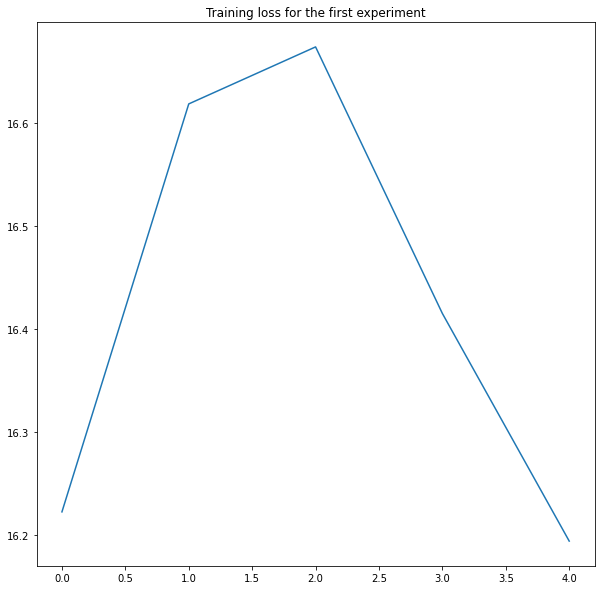

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(numpy.arange(len((f_train_history))), f_train_history)
plt.title("Training loss for the first experiment")

In [ ]:
actual_mask = f_validation_dataset.masks[0]
predicted_mask = first_trainer.network.forward

In [24]:
%%time
f_eval_metric = first_trainer.evaluate(f_validation_dataset)

RuntimeError: Failed to predict mask, check logs for more info

In [25]:
print('training loss for first trainer: %s' % str(f_train_loss))
print('evaluation metric f1-score for first trainer: %s' % str(f_eval_metric))

NameError: name 'f_train_loss' is not defined

In [ ]:
plt.figure((20, 30))
plt.plot(len(train_history), f_train_history)

In [ ]:
second_trainer = NetworkTrainer(
    network=network,
    optimizer=adam_opt,
    lr_schediler=adam_step_lr_scheduler,
    loss_function=dice_loss,
    train_device='cuda',
    max_epochs=50,
    batch_size=32,
)

In [ ]:
%%time
s_train_loss, s_train_history = second_trainer.train(s_train_dataset)

In [ ]:
%%time
s_eval_metric = second_trainer.evaluate(s_validation_dataset)

In [ ]:
print('training loss for second trainer: %s' % str(s_train_loss))
print('evaluation metric f1-score for second trainer: %s' % str(s_eval_metric))

In [ ]:
plt.figure((20, 30))
plt.plot(len(train_history), s_train_history)

### Saving best trainer to the corresponding file

In [ ]:
trainers = [first_trainer, second_trainer]
metrics = [f_eval_metric, s_eval_metric]
sets = [f_train_dataset.imgs[0], s_train_dataset.imgs[0]]
best_idx = numpy.argmax(metrics)

best_trainer = trainers[best_idx]
best_input = sets[best_idx]
best_metric = metrics[best_idx]

## Converting model to ONNX Format

In [ ]:
model_path = "../model/network.onnx"
best_trainer.save_network(model_path, best_input)